C:\Users\gtsch\AppData\Local\Temp\ipykernel_12332\375196934.py:62: RuntimeWarning: invalid value encountered in power
  delta_values_limited = (delta_0**3 - term * x_values_limited)**(1/3)


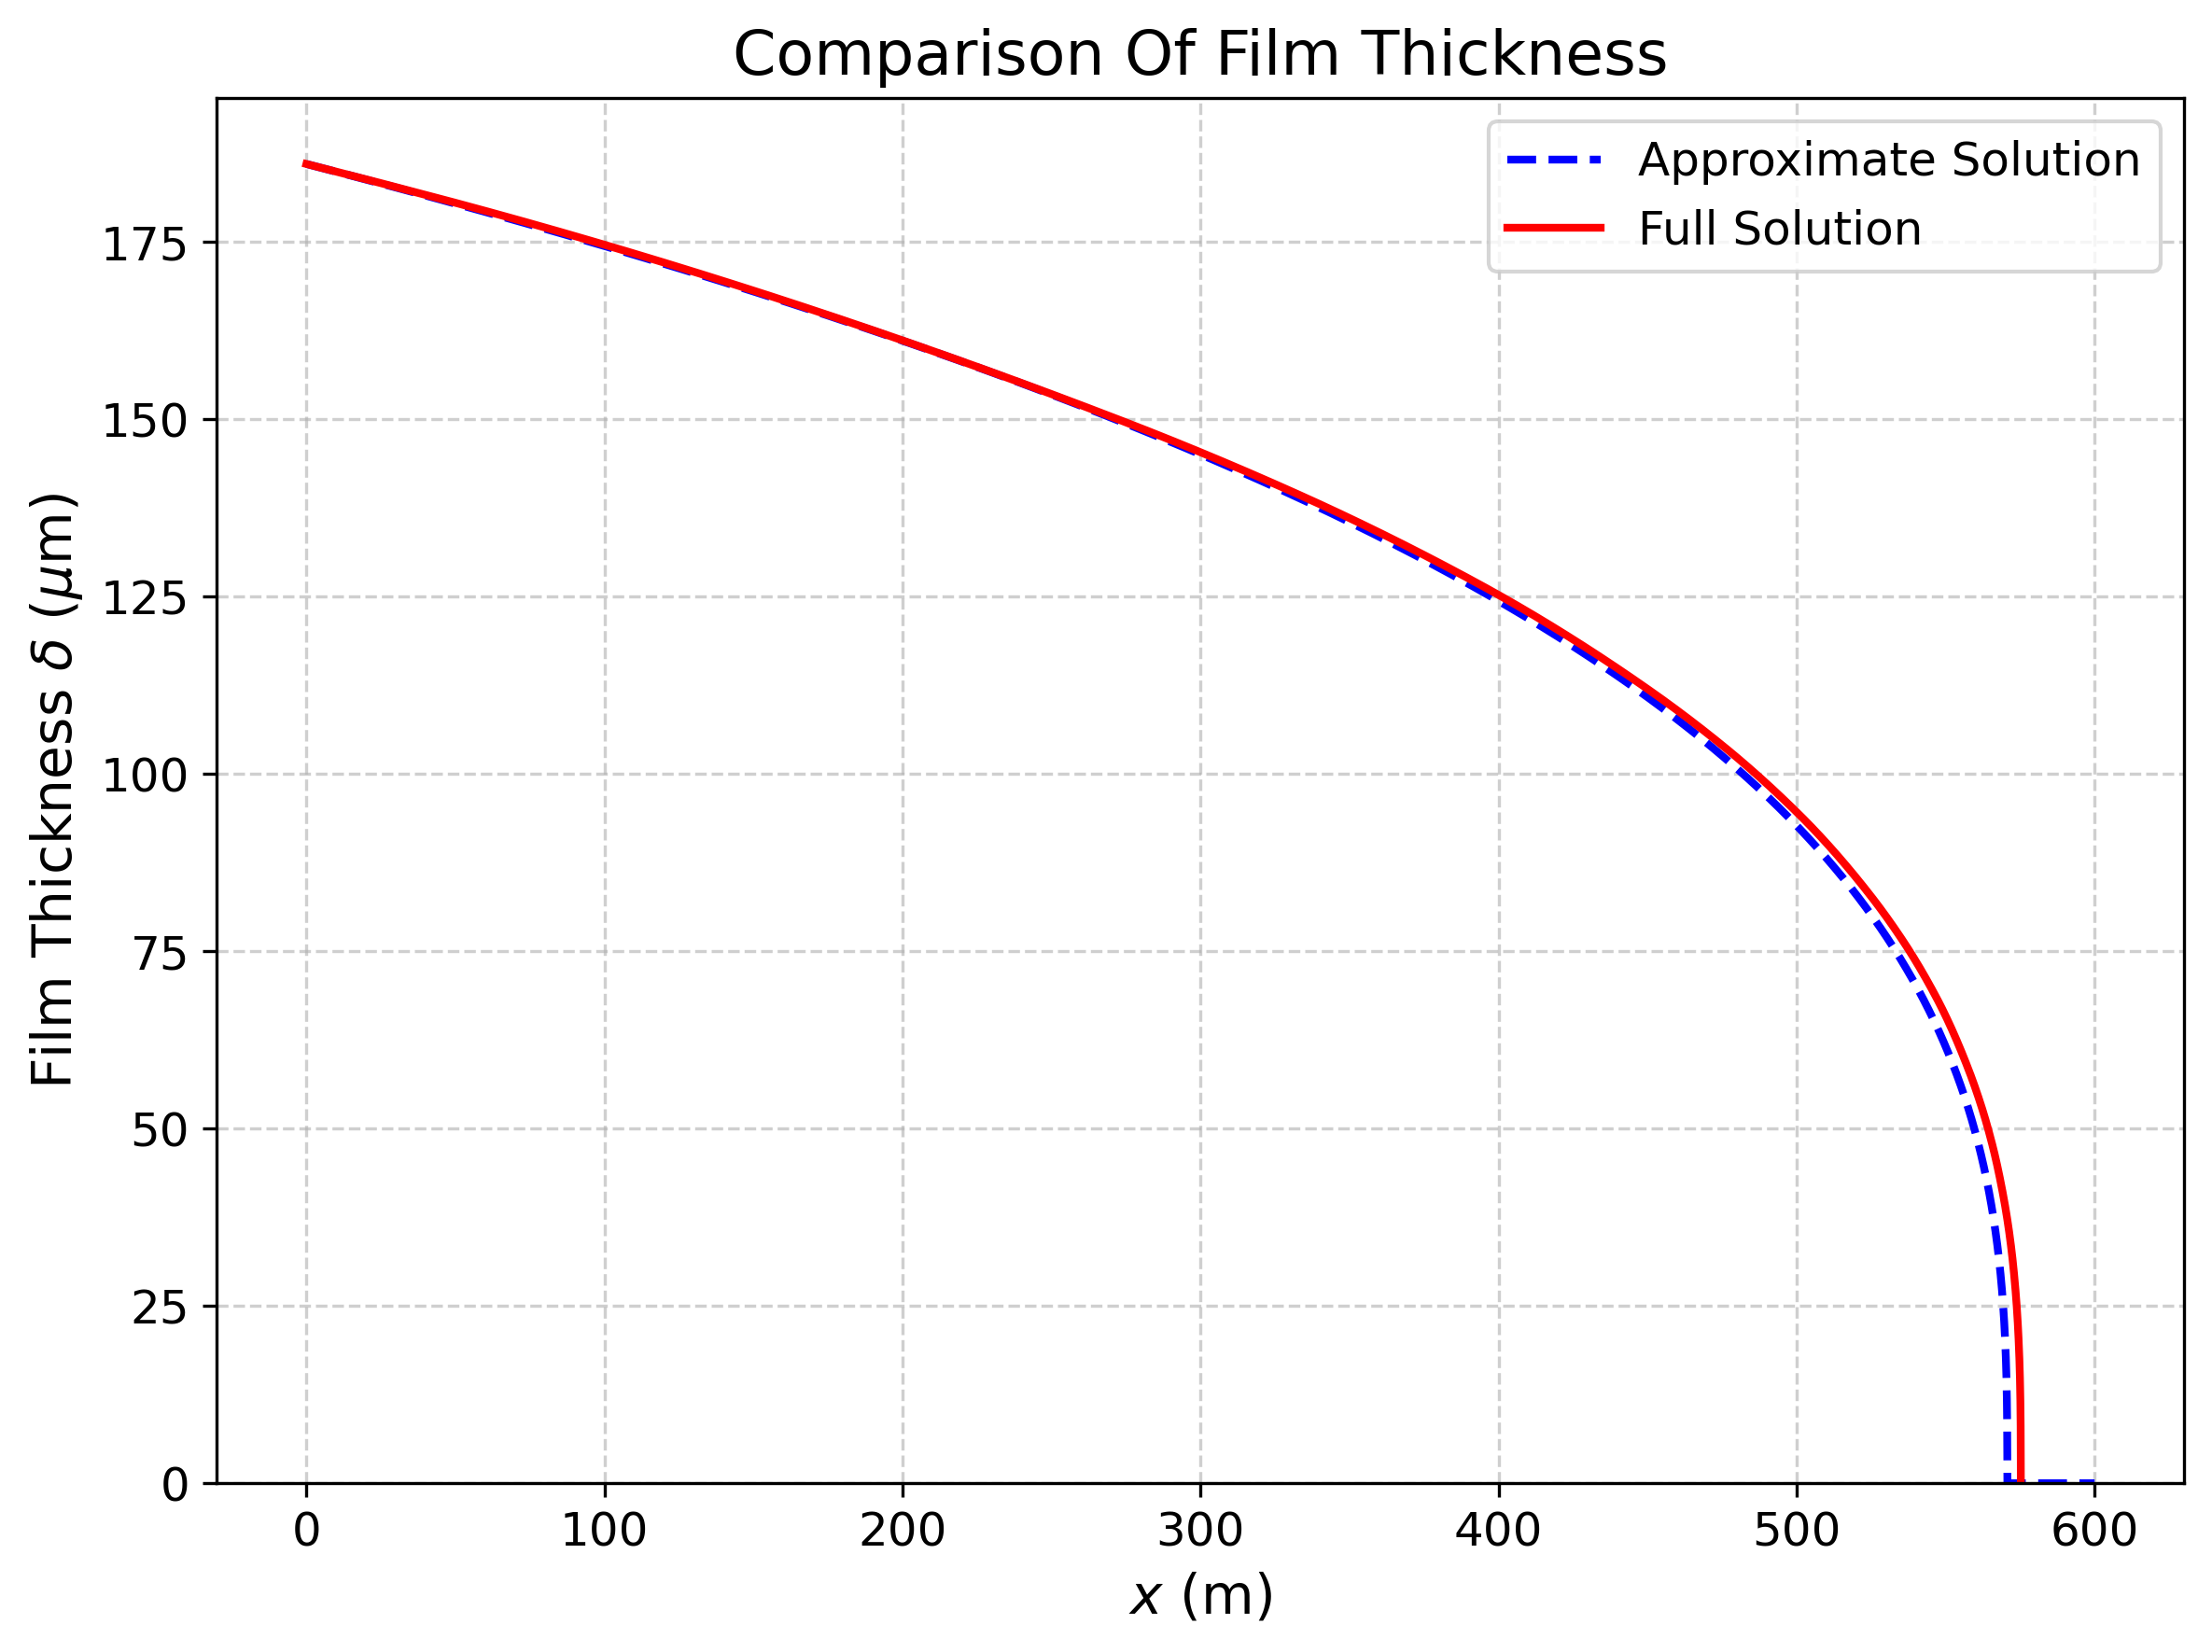

In [74]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Constants
mu = 1.8e-3       # Dynamic viscosity (kg/(m·s))
rho = 1000        # Density (kg/m^3)
g = 9.81          # Gravity (m/s^2)
h_m = 0.00089     # Mass transfer coefficient (m/s)
R_v = 461.5       # Specific gas constant for water vapor (J/kg·K)
k = 0.6           # Thermal conductivity of water (W/(m·K)) 
h_q = 5           # Heat transfer coefficient (W/(m^2·K))
L_v = 2.26e6      # Latent heat of vaporization (J/kg)

T_b_C = 30       # Panel Temp (C)
T_inf_C = 10     # Ambient temperature (C)
RH = 1.0  
T_b = T_b_C + 273.15
T_inf = T_inf_C + 273.15

# Clausius-Clapeyron
def e_s(T):
    T0 = 373.15  # Reference temperature (K)
    P0 = 101325  # Reference pressure (Pa)
    return P0 * np.exp(L_v / R_v * (1/T0 - 1/T))

e_inf = RH * e_s(T_inf) 

# Function to solve for T_delta
def T_delta_func(T_delta, delta):
    return T_b - (delta / k) * (h_q * T_inf - L_v * h_m * ((e_s(T_delta) / (R_v * T_delta)) - (e_inf / (R_v * T_inf)))) - T_delta

# Root-finding 
def find_T_delta(delta):
    try:
        new_bracket = [T_inf - 50, T_b + 50]  # Initial range
        sol = opt.root_scalar(T_delta_func, args=(delta,), bracket=new_bracket, method='brentq')
        return sol.root if sol.converged else T_b  
    except ValueError:
        return T_b  

# Define ODE with RH-dependent vapor concentration
def ddelta_dx_updated(x, delta):
    T_delta = find_T_delta(delta)  
    return - (mu * h_m) / (rho**2 * g * delta**2) * ((e_s(T_delta) / (R_v * T_delta)) - (e_inf / (R_v * T_inf)))

x = 600 # Length of domain in meters
x_span = (0, x)  
delta_0 = 0.000186  # Initial film thickness in meters

# Solve ODE
sol_updated = spi.solve_ivp(ddelta_dx_updated, x_span, [delta_0], method='LSODA', t_eval=np.linspace(0, x, 1000000))

# Extract numerical solution
x_values_numerical = sol_updated.t
delta_values_numerical = sol_updated.y[0] * 1e6 

# Analytical solution 
x_values_limited = np.linspace(0, x, 100000)
term = (3*mu * h_m / (rho**2 * g)) * (e_s(T_b) / (R_v * T_b) - e_inf / (R_v * T_inf))
delta_values_limited = (delta_0**3 - term * x_values_limited)**(1/3)
delta_values_limited = np.where(delta_values_limited > 0, delta_values_limited, 0) * 1e6 

# Create figure
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(x_values_limited, delta_values_limited, label=r'Approximate Solution', color='b', linestyle='--', linewidth=2)
plt.plot(x_values_numerical, delta_values_numerical, label=r'Full Solution', color='r', linewidth=2)
plt.xlabel(r'$x$ (m)', fontsize=14)
plt.ylabel(r'Film Thickness $\delta$ ($\mu$m)', fontsize=14)
plt.title(r'Comparison Of Film Thickness', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 3))
plt.ylim(bottom=0, top=max(np.max(delta_values_numerical), np.max(delta_values_limited)) * 1.05)
plt.tight_layout()
plt.show()


In [75]:
# x-location where the film thickness first reaches zero
zero_index_numerical = np.where(delta_values_numerical <= 0)[0]

if zero_index_numerical.size > 0:
    x_zero_numerical = x_values_numerical[zero_index_numerical[0]]
    print(f"Film reaches zero thickness (numerical) at x = {x_zero_numerical:.6f} m")
else:
    print("Film does not reach zero thickness in the numerical solution.")

zero_index_analytical = np.where(delta_values_limited <= 0)[0]

if zero_index_analytical.size > 0:
    x_zero_analytical = x_values_limited[zero_index_analytical[0]]
    print(f"Film reaches zero thickness (analytical) at x = {x_zero_analytical:.6f} m")
else:
    print("Film does not reach zero thickness in the analytical solution.")

difference =  x_zero_numerical  - x_zero_analytical 

print(f"Difference between analytical and numerical solution: {difference:.6f} m")  


Film reaches zero thickness (numerical) at x = 575.235575 m
Film reaches zero thickness (analytical) at x = 570.713707 m
Difference between analytical and numerical solution: 4.521868 m


In [76]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

analytical_interp = interp1d(x_values_limited, delta_values_limited, kind='linear', fill_value='extrapolate')
delta_analytical_at_numerical_x = analytical_interp(x_values_numerical)

# Compute RMSE
mse = mean_squared_error(delta_values_numerical, delta_analytical_at_numerical_x)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}m')


Root Mean Squared Error: 10.660906577025212m
